In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow_addons as tfa
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.utils import to_categorical
import os
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Reshape, Activation, Dot
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, LayerNormalization, Normalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from google.colab import files
import zipfile
import os
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vinumagdum114","key":"0bce0337459598673b64c02510600884"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 609M/612M [00:05<00:00, 158MB/s]
100% 612M/612M [00:05<00:00, 122MB/s]


In [7]:
# Specify the path of the uploaded ZIP file
zip_path = '/content/gtsrb-german-traffic-sign.zip'

# Specify the directory path where you want to extract the contents
extract_path = '/content/extracted_images'

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extraction by listing the files in the extracted directory
file_list = os.listdir(extract_path)
print(file_list)

['test', 'train', 'meta', 'Meta', 'Train.csv', 'Train', 'Test', 'Meta.csv', 'Test.csv']


## Define dataset path

## Define ImageDataGenerator class for image augmentation

In [28]:
train_folder = '/content/extracted_images/Train'
test_folder = '/content/extracted_images'

train_datagen = ImageDataGenerator(
    validation_split = 0.3,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=False,
    vertical_flip=False
)
test_datagen = ImageDataGenerator()

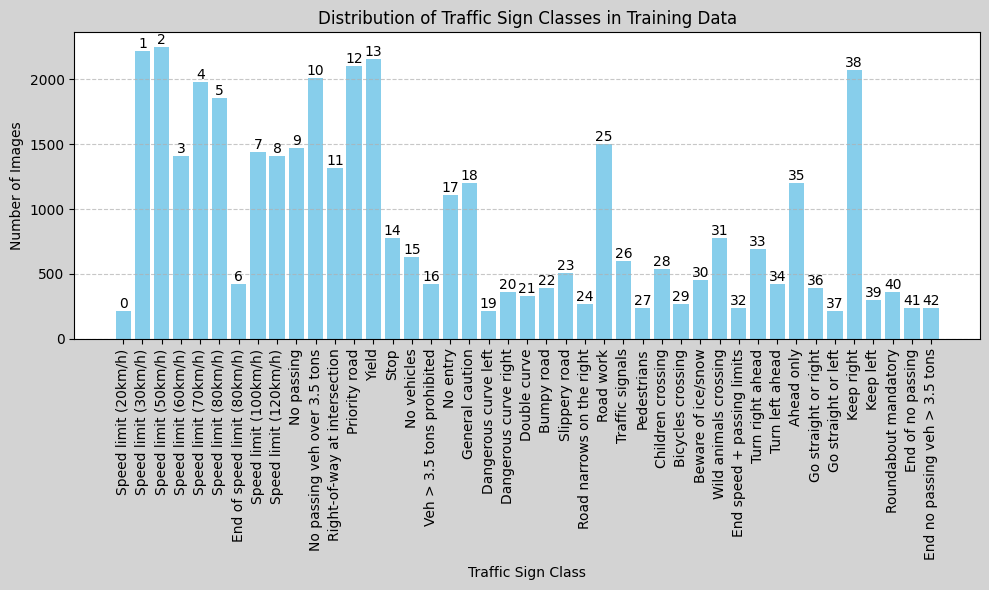

In [44]:
# Load the training data set of GTSRB
training_data = pd.read_csv('/content/extracted_images/Train.csv')

# Mapping ClassID values to their corresponding labels
classes= {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)',
    2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)',
    4:'Speed limit (70km/h)',
    5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)',
    7:'Speed limit (100km/h)',
    8:'Speed limit (120km/h)',
    9:'No passing',
    10:'No passing veh over 3.5 tons',
    11:'Right-of-way at intersection',
    12:'Priority road',
    13:'Yield',
    14:'Stop',
    15:'No vehicles',
    16:'Veh > 3.5 tons prohibited',
    17:'No entry',
    18:'General caution',
    19:'Dangerous curve left',
    20:'Dangerous curve right',
    21:'Double curve',
    22:'Bumpy road',
    23:'Slippery road',
    24:'Road narrows on the right',
    25:'Road work',
    26:'Traffic signals',
    27:'Pedestrians',
    28:'Children crossing',
    29:'Bicycles crossing',
    30:'Beware of ice/snow',
    31:'Wild animals crossing',
    32:'End speed + passing limits',
    33:'Turn right ahead',
    34:'Turn left ahead',
    35:'Ahead only',
    36:'Go straight or right',
    37:'Go straight or left',
    38:'Keep right',
    39:'Keep left',
    40:'Roundabout mandatory',
    41:'End of no passing',
    42:'End no passing veh > 3.5 tons'
}
# Group the data by class and count the occurrences of each class
class_counts = training_data['ClassId'].value_counts().sort_index()

# Convert class_counts to DataFrame for sorting
class_counts_df = pd.DataFrame({'ClassID': class_counts.index, 'Count': class_counts.values})

# Sort the DataFrame by the 'Count' column
class_counts_sorted = class_counts_df.sort_values(by='Count')

# Plotting
plt.figure(figsize=(10, 6), facecolor='lightgrey')
bars = plt.bar(class_counts_sorted['ClassID'], class_counts_sorted['Count'], color='skyblue')
plt.xlabel('Traffic Sign Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Traffic Sign Classes in Training Data')
plt.xticks(class_counts_sorted['ClassID'], [classes[class_id] for class_id in class_counts_sorted['ClassID']], rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add ClassID values on the bars
for bar, class_id in zip(bars, class_counts_sorted['ClassID']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, class_id, ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [51]:
import seaborn as sns  # Import seaborn for additional styling

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    # Select the columns you want to include in the histogram plot
    selected_columns = ['Width', 'Height']
    df = df[selected_columns]

    # Determine the number of rows and columns for subplots
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow  # Integer division

    # Create the figure for subplots
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    # Plot histograms for each selected column
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar(color='skyblue')  # Change color to sky blue
        else:
            columnDf.hist(color='orange')  # Change histogram color to orange
        plt.ylabel('Counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')

    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

def plot_correlation_matrix(df, graph_width, dataframe_name):
    # Select only numeric columns
    df_numeric = df.select_dtypes(include=['number'])

    # Drop columns with NaN values
    df_numeric = df_numeric.dropna(axis=1)

    # Check if there are enough columns remaining for correlation calculation
    if df_numeric.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df_numeric.shape[1]}) is less than 2')
        return

    # Calculate correlation matrix
    corr = df_numeric.corr()

    # Plot correlation matrix with seaborn for better visualization
    plt.figure(num=None, figsize=(graph_width, graph_width), dpi=80, facecolor='w', edgecolor='k')
    sns.heatmap(corr, annot=True, cmap='coolwarm')  # Use seaborn heatmap with 'coolwarm' colormap
    plt.title(f'Correlation Matrix for {dataframe_name}', fontsize=15)
    plt.show()

def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])  # keep only numerical columns
    # Remove rows that have missing values
    df = df.dropna()
    df = df.loc[:, df.nunique() > 1]  # keep columns where there are more than 1 unique values
    columnNames = list(df.columns)
    if len(columnNames) > 10:  # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')

    # Add regression lines to scatter plots
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i != j:
                ax[i, j].plot(df.iloc[:, j], df.iloc[:, i], 'o', color='skyblue')  # Change scatter plot color to sky blue
                z = np.polyfit(df.iloc[:, j], df.iloc[:, i], 1)
                p = np.poly1d(z)
                ax[i, j].plot(df.iloc[:, j], p(df.iloc[:, j]), "--", color="orange")  # Add regression line in orange

    corrs = df.corr().values
    for i, j in zip(*np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

**Train_CSV**

In [56]:
df3 = pd.read_csv('/content/extracted_images/Train.csv', delimiter=',')
df3.dataframeName = 'Meta.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')
df3.head()

There are 39209 rows and 8 columns


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


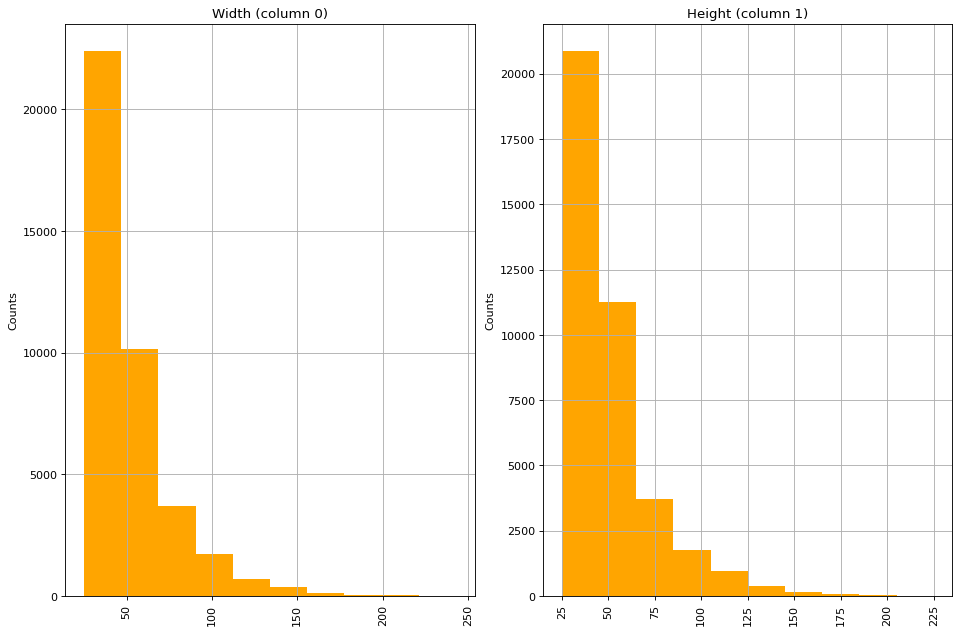

In [57]:
plotPerColumnDistribution(df3, 10, 5)

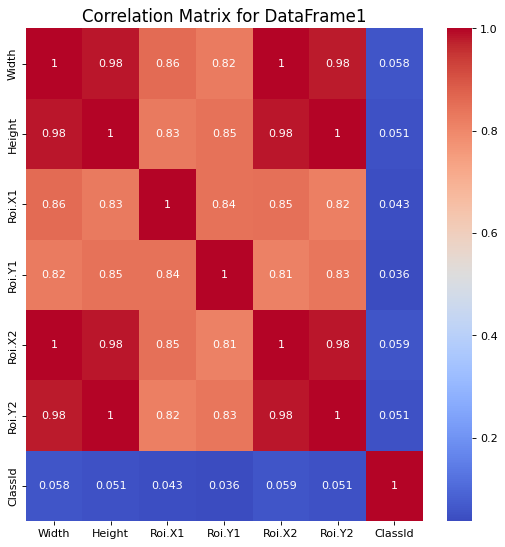

In [58]:
plot_correlation_matrix(df3, 8, 'DataFrame1')

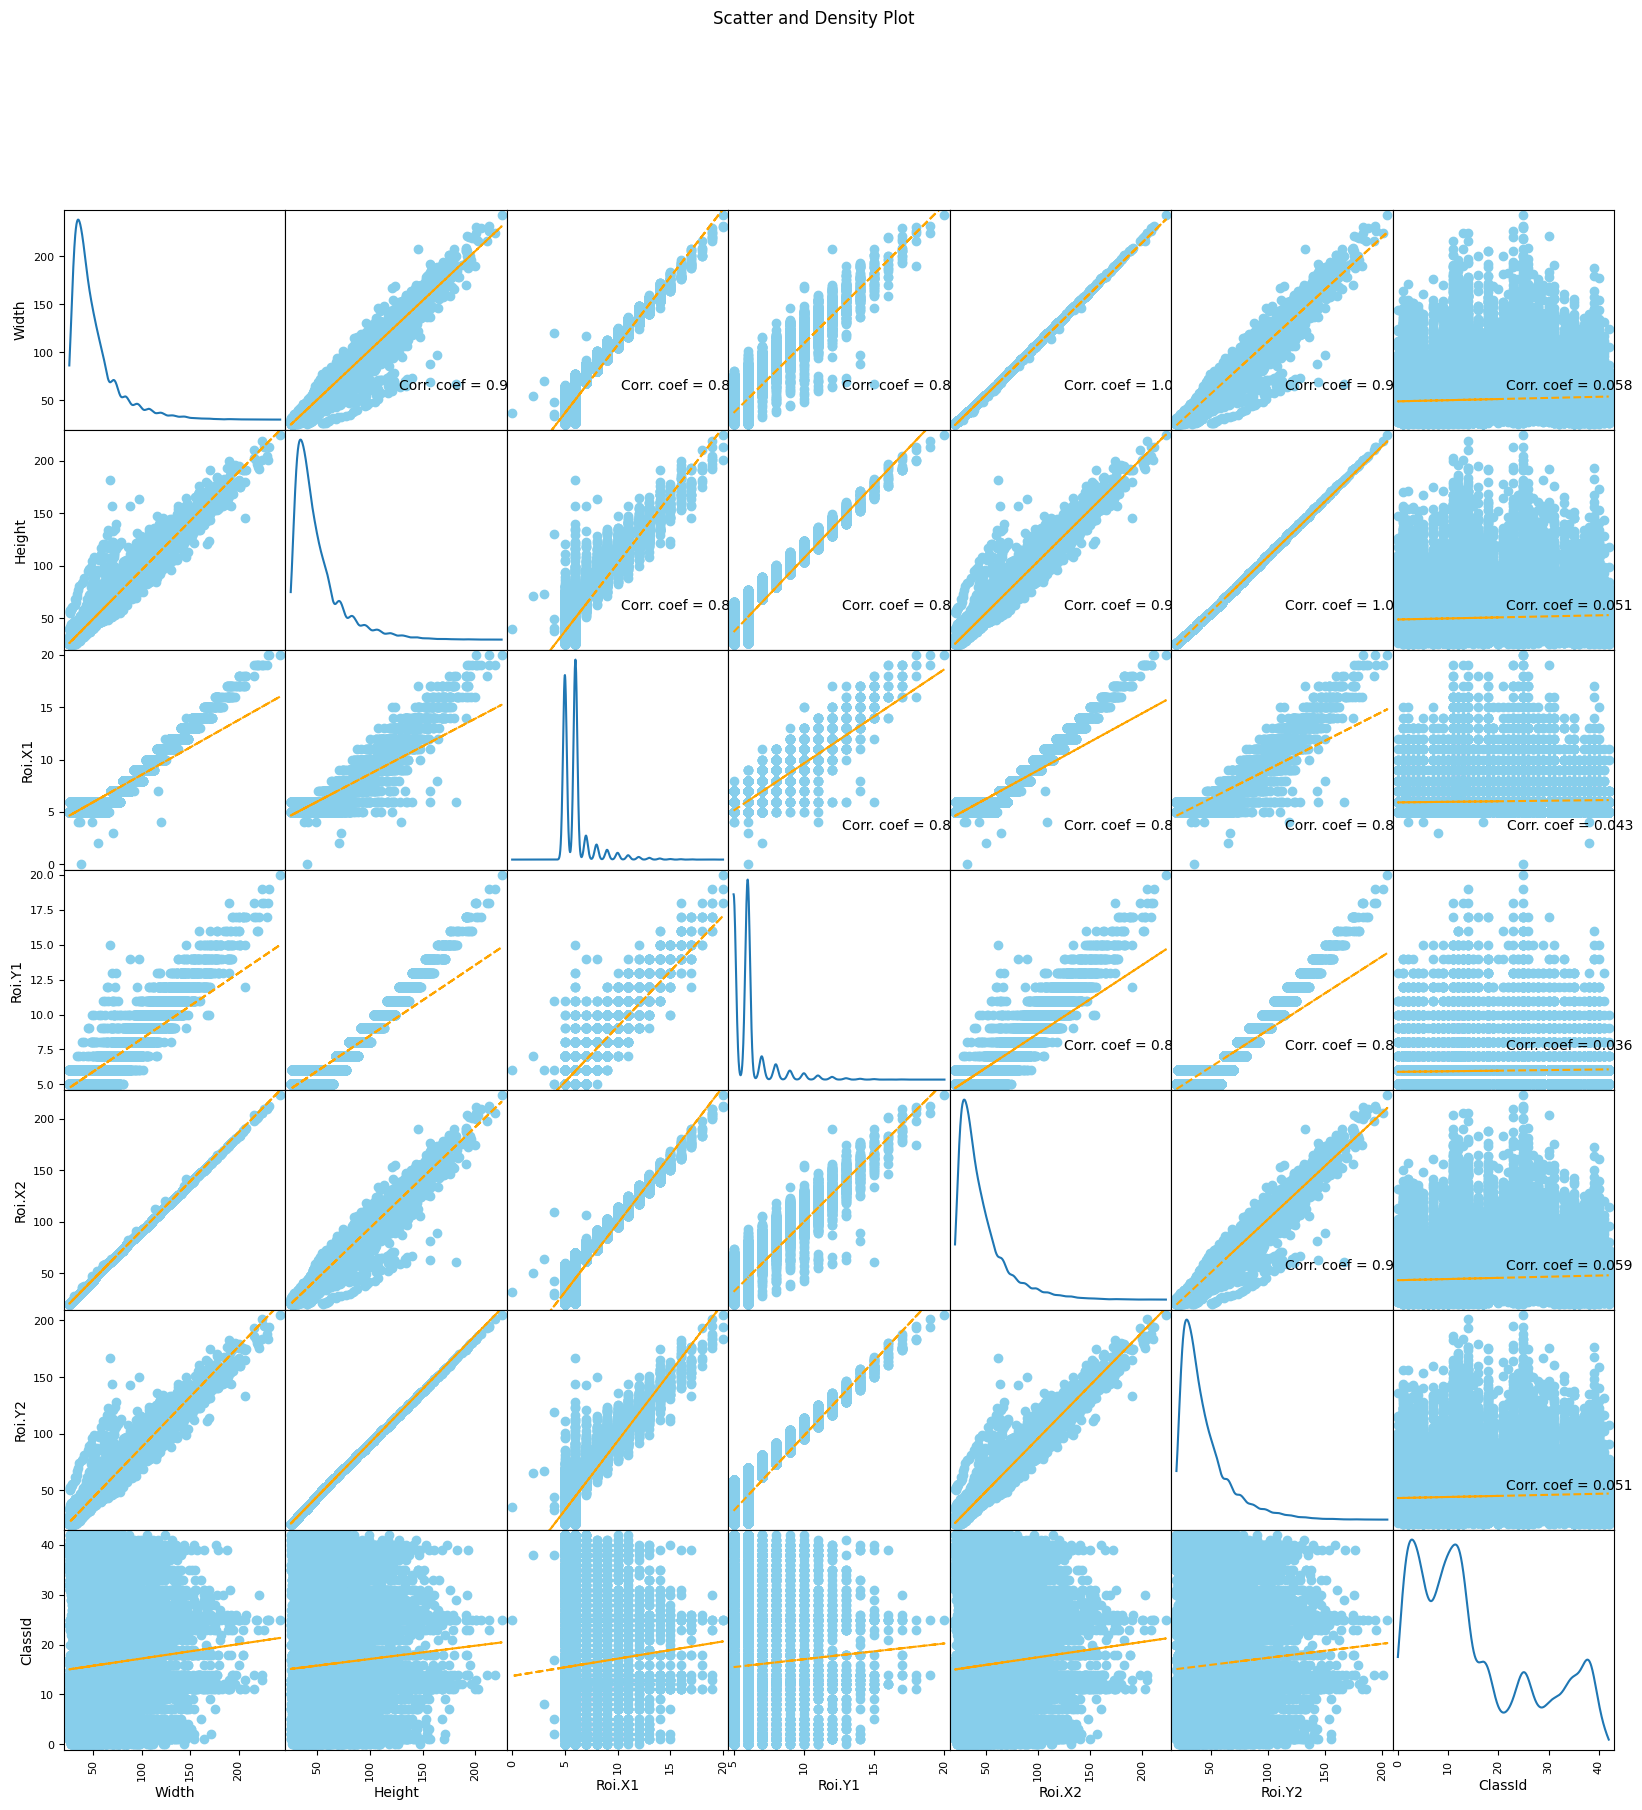

In [59]:
plotScatterMatrix(df3, 20, 10)

**Test_CSV**

In [60]:
df2 = pd.read_csv('/content/extracted_images/Test.csv', delimiter=',')
df2.dataframeName = 'Meta.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')
df2.head()

There are 12630 rows and 8 columns


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


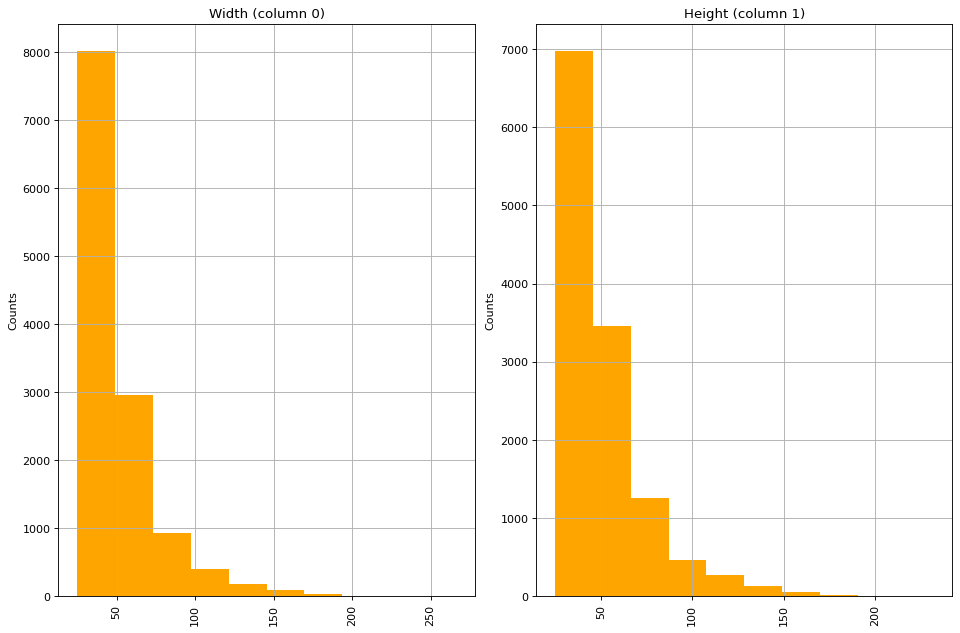

In [61]:
plotPerColumnDistribution(df2, 10, 5)

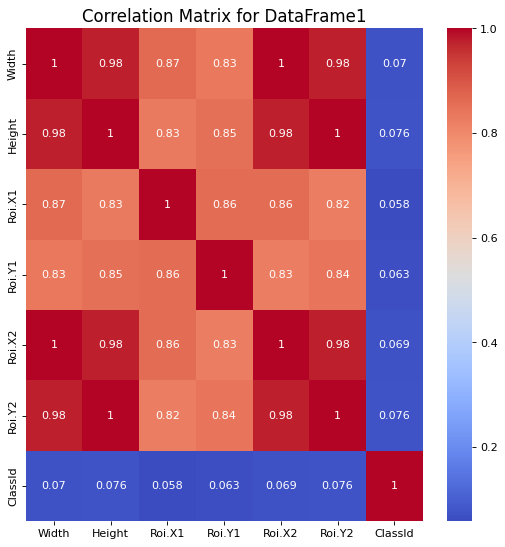

In [62]:
plot_correlation_matrix(df2, 8, 'DataFrame1')

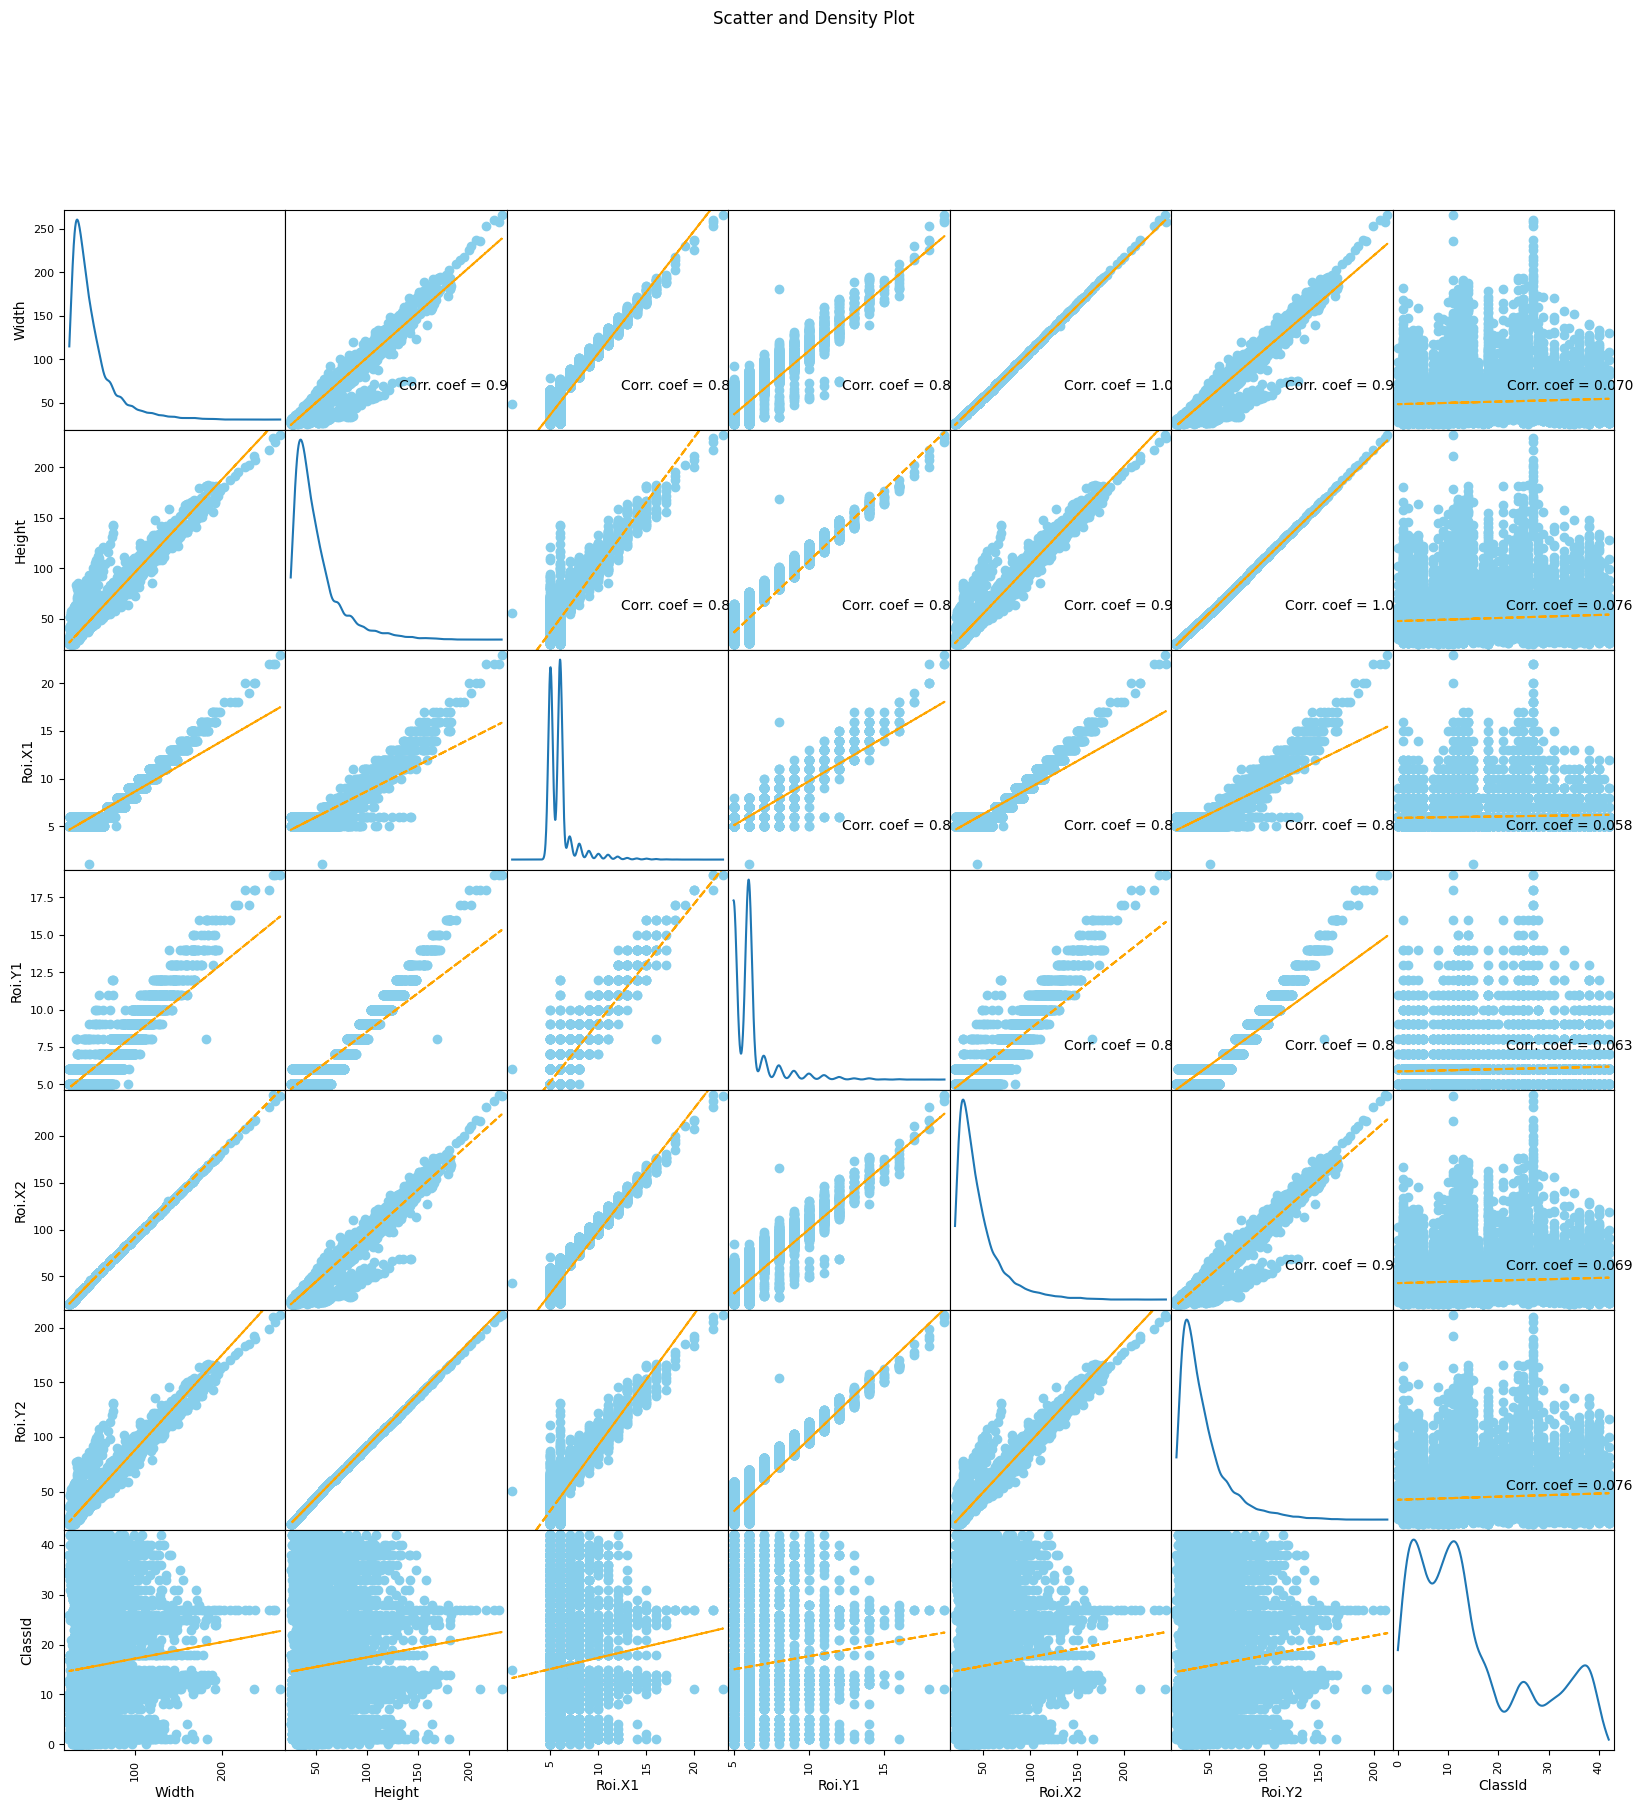

In [63]:
plotScatterMatrix(df2, 20, 10)

**Meta_CSV**

In [47]:
df1 = pd.read_csv('/content/extracted_images/Meta.csv', delimiter=',')
df1.dataframeName = 'Meta.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df1.head(5)

There are 43 rows and 5 columns


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


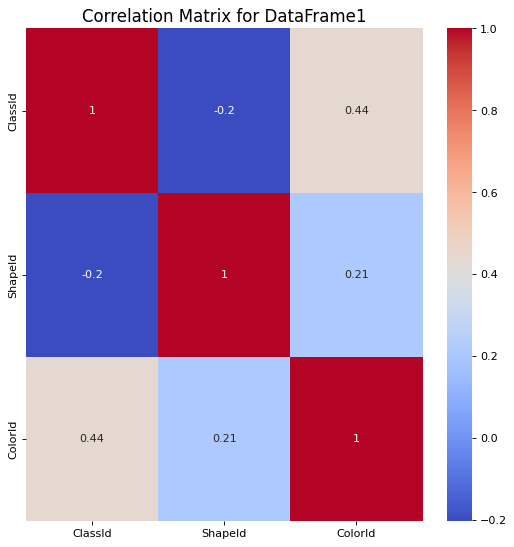

In [53]:
plot_correlation_matrix(df1, 8, 'DataFrame1')

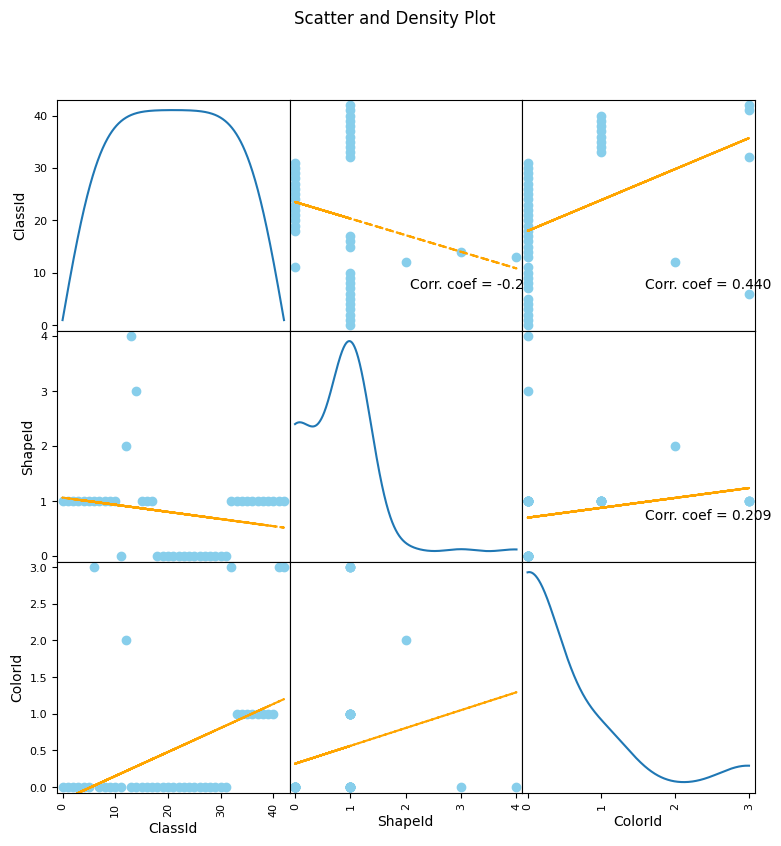

In [54]:
plotScatterMatrix(df1, 9, 10)

## Define image size and set seed for reproducibility

In [12]:
num_classes = len(classes)
target_size_x = 48
target_size_y = 48
seed = 123
batch_size = 32
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
import pandas as pd
df = pd.read_csv('/content/extracted_images/Test.csv', delimiter=',')
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


## Load traing set and converts the class vector (integers) to binary class matrix

In [14]:
x_train = []
y_train = []
for i in tqdm(range(len(classes))):
    for imgFile in os.listdir(os.path.join(train_folder, str(i))):
        img_path = os.path.join(os.path.join(train_folder, str(i)), imgFile)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (target_size_x,target_size_y))

        x_train.append(image/255.0)
        y_train.append(i)

100%|██████████| 43/43 [00:17<00:00,  2.53it/s]


In [15]:
x_train = np.array(x_train, dtype = 'float32')
y_train = np.array(y_train, dtype = 'int32')
y_train = keras.utils.to_categorical(y_train, num_classes=43)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
print("x_train.shape", x_train.shape)
print("x_valid.shape", x_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

x_train.shape (31367, 48, 48, 3)
x_valid.shape (7842, 48, 48, 3)
y_train.shape (31367, 43)
y_valid.shape (7842, 43)


In [16]:
train_flow = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
val_flow = test_datagen.flow(
    x_val, y_val,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

## Local Contrast Normalisation

In [17]:
class LRN2D(tf.keras.layers.Layer):
    """
    Local Contrast Normalisation
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__()
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = X.shape
        half_n = self.n // 2
        input_sqr = T.sqr(X)
        extra_channels = T.alloc(0., b, ch + 2*half_n, r, c)
        input_sqr = T.set_subtensor(extra_channels[:, half_n:half_n+ch, :, :], input_sqr)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        return {"name": self.__class__.__name__,
                "alpha": self.alpha,
                "k": self.k,
                "beta": self.beta,
                "n": self.n}

## Define a compact CNN model

In [18]:
def creat_cnn_model():
    inputs = layers.Input((target_size_x, target_size_y, 3))

    norm = Normalization(mean=[0.4914, 0.4822, 0.4465],
                  variance=[np.square(0.247),
                            np.square(0.243),
                            np.square(0.261)])(inputs)

    x = Conv2D(filters=200, kernel_size=(7,7), padding='valid', activation='relu', kernel_initializer="he_normal")(norm)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = LRN2D()(x)

    x = Conv2D(filters=250, kernel_size=(4,4), padding='valid', activation='relu', kernel_initializer="he_normal")(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = LRN2D()(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(filters=350, kernel_size=(4,4), padding='valid', activation='relu', kernel_initializer="he_normal")(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = LRN2D()(x)
    x = Dropout(rate=0.25)(x)

    x = Flatten()(x)
    x = Dense(400, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    classifier = Dense(43, activation='softmax')(x)
    return keras.Model(inputs=inputs, outputs=classifier)

In [19]:
model = creat_cnn_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 normalization (Normalizati  (None, 48, 48, 3)         0         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 42, 42, 200)       29600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 21, 200)       0         
 D)                                                              
                                                                 
 lrn2d (LRN2D)               (None, 21, 21, 200)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 250)       800250

## Define class for cosinedecay learning rate

In [20]:
class CosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, min_lr, max_lr, warmup_steps=4000, alpha=0):
        super(CosineDecay, self).__init__()

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps
        self.max_steps = warmup_steps * 10
        self.alpha = alpha

    def __call__(self, step):
        arg1 = (self.max_lr - self.min_lr) * step / self.warmup_steps + self.min_lr
        min_step = tf.math.minimum(step, self.max_steps)
        cosine_decay = 0.5 * (1 + tf.math.cos(np.pi * min_step / self.max_steps))
        decayed = (1 - self.alpha) * cosine_decay + self.alpha
        arg2 = (self.max_lr - self.min_lr) * decayed + self.min_lr
        return tf.math.minimum(arg1, arg2)

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print("\nEpoch %05d: Current learning rate is %6.4f." % (epoch, lr))

## Training the model

In [21]:
epochs = 30   # number of all epochs in training
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
batches = int(len(x_train) / batch_size)  # number of training batch to run per epoch

warmup_steps = batches * 5
learning_rate = CosineDecay(
    min_lr=1E-5, max_lr=1E-2, warmup_steps=warmup_steps
)

checkpoint = ModelCheckpoint(
      filepath='cnn48-{epoch:02d}-{val_acc:.4f}.h5',
      save_weights_only=True,
      monitor='val_acc',
      mode='max',
      save_best_only=True,
      initial_value_threshold=0.995)

earlystop = EarlyStopping(
      monitor='val_loss', patience=stop_patience, mode='min', restore_best_weights=True)

loss_fn = tf.keras.losses.CategoricalCrossentropy()

optimizer = keras.optimizers.SGD(learning_rate=0.02)


model.compile(
        optimizer, loss=loss_fn,
        metrics=[
        keras.metrics.CategoricalAccuracy(name="acc"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
history = model.fit(
    x = train_flow,
    batch_size=batch_size,
    validation_data=val_flow,
    steps_per_epoch=batches,
    verbose=1,
    epochs=epochs,
    callbacks=[checkpoint, earlystop],
    validation_steps= None,
    shuffle= False,
)

Epoch 1/30
980/980 [==============================] - 51s 45ms/step - loss: 2.3156 - acc: 0.3581 - top-5-accuracy: 0.6784 - val_loss: 0.7733 - val_acc: 0.7933 - val_top-5-accuracy: 0.9712
Epoch 2/30
980/980 [==============================] - 51s 52ms/step - loss: 0.9741 - acc: 0.6916 - top-5-accuracy: 0.9422 - val_loss: 0.2103 - val_acc: 0.9473 - val_top-5-accuracy: 0.9980
Epoch 3/30
980/980 [==============================] - 44s 45ms/step - loss: 0.5367 - acc: 0.8319 - top-5-accuracy: 0.9802 - val_loss: 0.0942 - val_acc: 0.9791 - val_top-5-accuracy: 0.9995
Epoch 4/30
980/980 [==============================] - 45s 46ms/step - loss: 0.3484 - acc: 0.8900 - top-5-accuracy: 0.9900 - val_loss: 0.0372 - val_acc: 0.9909 - val_top-5-accuracy: 0.9999
Epoch 5/30
980/980 [==============================] - 43s 44ms/step - loss: 0.2521 - acc: 0.9229 - top-5-accuracy: 0.9933 - val_loss: 0.0314 - val_acc: 0.9929 - val_top-5-accuracy: 0.9999
Epoch 6/30
980/980 [==============================] - 43s 44

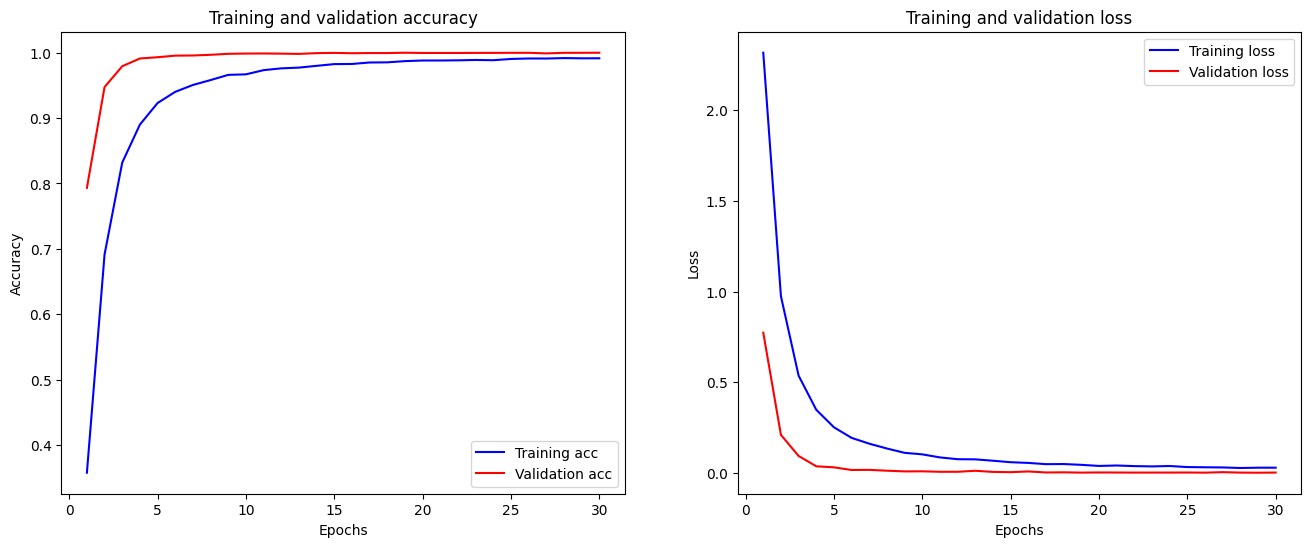

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1,2,figsize = (16,6))
axs[0].plot(epochs, acc, 'b', label='Training acc')
axs[0].plot(epochs, val_acc, 'r', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(epochs, loss, 'b', label='Training loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

In [29]:
labels = df["ClassId"].values
imgs = df["Path"].values

x_test = []

for img in tqdm(imgs):
    try:
        image = cv2.imread(test_folder + '/' +img)
        image = cv2.resize(image, (target_size_x,target_size_y))

        x_test.append(image/255.0)
    except:
        print("Error in " + img)

x_test = np.array(x_test, dtype = 'float32')
y_test = keras.utils.to_categorical(labels, num_classes=43)

100%|██████████| 12630/12630 [00:02<00:00, 4897.55it/s]


## Evaluate

In [40]:
y_pred = model.predict(x_test)
test_result = model.evaluate(x_test, y_test)

print("Test loss : ", test_result[0])
print("Test accuracy :", test_result[1]*100, "%")

395/395 [==============================] - 4s 9ms/step - loss: 0.0603 - acc: 0.9846 - top-5-accuracy: 0.9977
Test loss :  0.060319967567920685
Test accuracy : 98.45605492591858 %


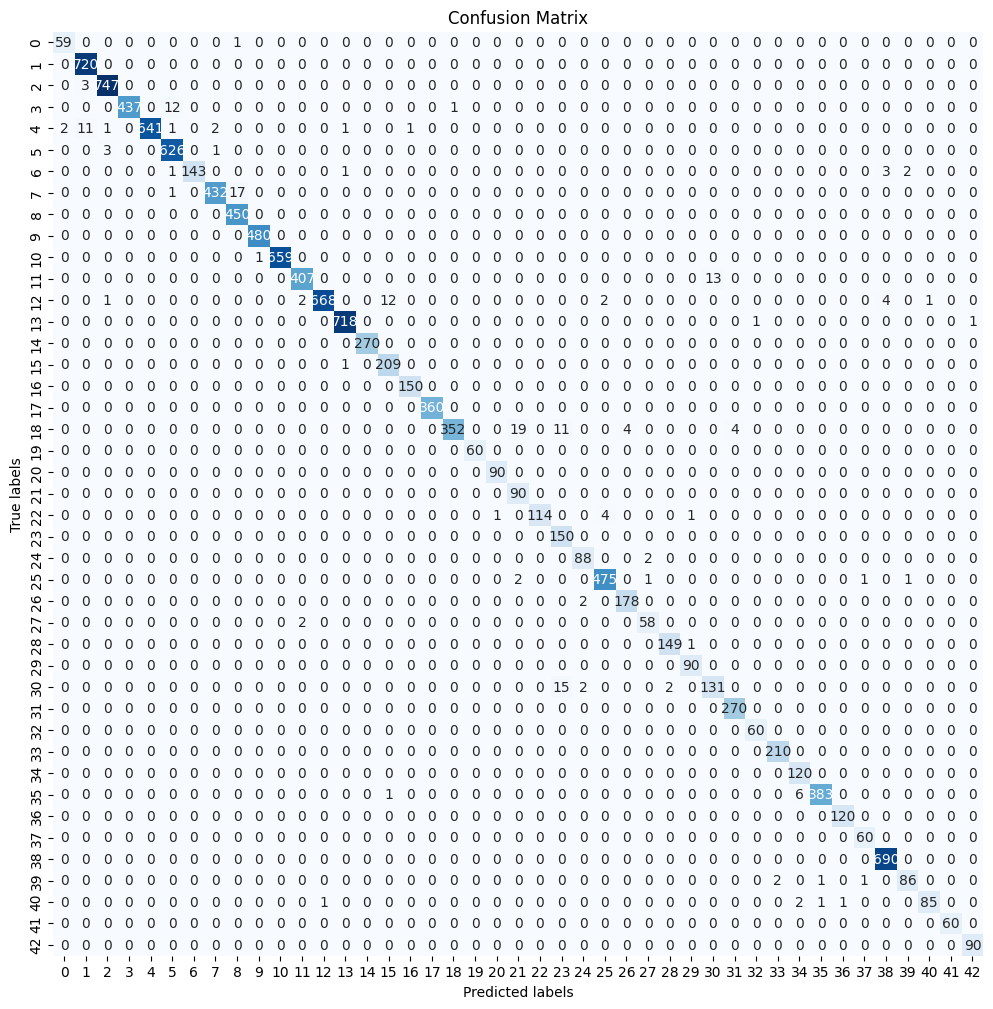

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       0.98      1.00      0.99       720
           2       0.99      1.00      0.99       750
           3       1.00      0.97      0.99       450
           4       1.00      0.97      0.99       660
           5       0.98      0.99      0.99       630
           6       1.00      0.95      0.98       150
           7       0.99      0.96      0.98       450
           8       0.96      1.00      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.97      0.98       420
          12       1.00      0.97      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.94      1.00      0.97       210
          16       0.99      1.00      1.00       150
          17       1.00    

In [42]:
# Convert model architecture to JSON format
model_json = model.to_json()

# Save model architecture to a JSON file
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved to 'model_architecture.json'.")

Model architecture saved to 'model_architecture.json'.
